## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.model_selection as skl
from skimage.io import imread, imshow
from itertools import chain
from random import sample
from keras.preprocessing.image import ImageDataGenerator

## Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
## Todo
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
22645,00005992_000.png,No Finding,0,5992,73,M,PA,2048,2500,0.171,0.171,NaN,/data/images_003/images/00005992_000.png
40864,00010589_001.png,No Finding,1,10589,52,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010589_001.png
78913,00019373_000.png,Mass|Pneumothorax,0,19373,39,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00019373_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
## Todo

# Defining all labels and number of disease per patient
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(50)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
28831,00007526_024.png,No Finding,24,7526,65,M,PA,2824,2647,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
110902,00030247_000.png,No Finding,0,30247,54,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66292,00016400_002.png,No Finding,2,16400,37,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
53023,00013377_016.png,Infiltration,16,13377,39,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
42614,00010973_004.png,No Finding,4,10973,75,M,PA,2862,2887,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5875,00001582_016.png,No Finding,16,1582,33,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
73792,00018146_000.png,Atelectasis|Fibrosis|Infiltration|Mass,0,18146,38,F,PA,2992,2991,0.143000,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
103321,00027556_003.png,Mass|Nodule,3,27556,63,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
83051,00020408_024.png,No Finding,24,20408,45,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67171,00016587_073.png,Emphysema,73,16587,46,F,PA,2482,2991,0.143000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
## Todo

conditions = [all_xray_df.Pneumonia==1, all_xray_df.Pneumonia==0]
values = ['pneumonia', 'no_pneumonia']
all_xray_df['pneumonia_class'] = np.select(conditions, values)


In [5]:
all_xray_df.sample(50)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
17371,00004669_000.png,No Finding,0,4669,18,F,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no_pneumonia
79100,00019415_000.png,No Finding,0,19415,28,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no_pneumonia
11420,00003005_015.png,Pneumothorax,15,3005,50,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,no_pneumonia
75633,00018558_006.png,Nodule,6,18558,32,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no_pneumonia
100058,00026515_006.png,Atelectasis,6,26515,66,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_pneumonia
100499,00026654_000.png,Infiltration,0,26654,67,M,PA,2992,2991,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no_pneumonia
102687,00027377_000.png,No Finding,0,27377,55,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no_pneumonia
62945,00015561_010.png,Edema,10,15561,56,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_pneumonia
54414,00013657_000.png,No Finding,0,13657,35,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no_pneumonia
108762,00029513_003.png,No Finding,3,29513,56,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no_pneumonia


## Create your training and testing data:

In [6]:
# def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    
    
    # return train_data, val_data
    
train_df, valid_df = skl.train_test_split(all_xray_df, test_size=0.2, stratify=all_xray_df['Pneumonia'])
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [7]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

In [8]:
# The data split made sure that there is the same proportion of pneumonia in both training and validation sets
# We need to create a class balance in training set between pneumonia and no_pnumonia classes 50-50:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [9]:
# No we process validation dataset to reflect 20-80 ratio of pneumonia to no_pneumonia which reflects real world data
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

In [29]:
len(train_df)

2290

In [30]:
len(valid_df)

1430

(0.0, 150.0)

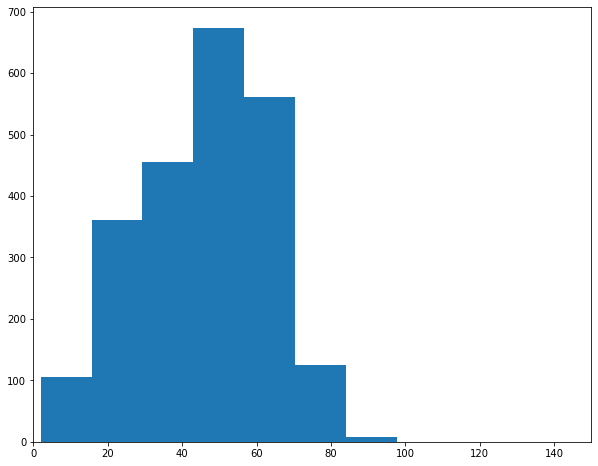

In [31]:
plt.figure(figsize = (10,8))
plt.hist(train_df['Patient Age'], bins=30)
plt.xlim([0,150])

(0.0, 150.0)

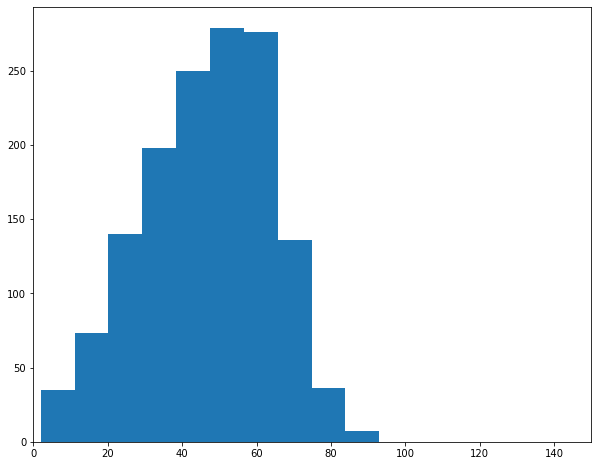

In [32]:
plt.figure(figsize = (10,8))
plt.hist(valid_df['Patient Age'])
plt.xlim([0,150])

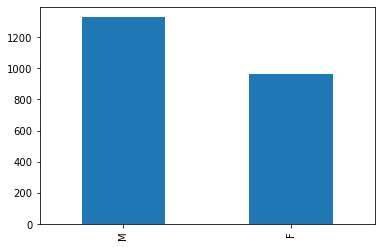

In [33]:
train_df['Patient Gender'].value_counts().plot(kind='bar')

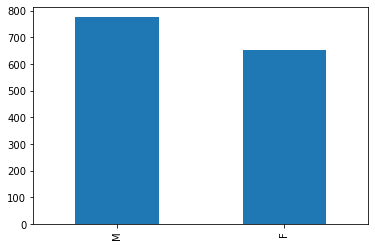

In [34]:
valid_df['Patient Gender'].value_counts().plot(kind='bar')

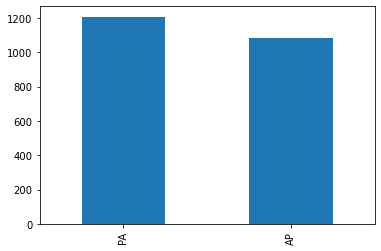

In [17]:
train_df['View Position'].value_counts().plot(kind='bar')

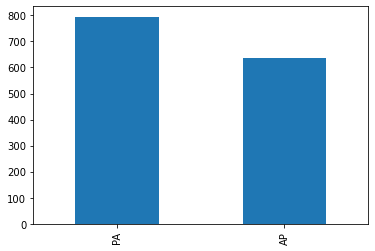

In [18]:
valid_df['View Position'].value_counts().plot(kind='bar')

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [14]:
# def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
train_idg = ImageDataGenerator(rescale = 1./255,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=10, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    # return my_idg


# def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 10
                                         )
    # return train_gen


# def make_val_gen(vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    
val_idg = ImageDataGenerator(rescale = 1. / 255
                                 )
val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                      directory=None, 
                                      x_col = 'path',
                                      y_col = 'pneumonia_class',
                                      class_mode = 'binary',
                                      target_size = (224,224), 
                                      batch_size = 6)
    # return val_gen

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

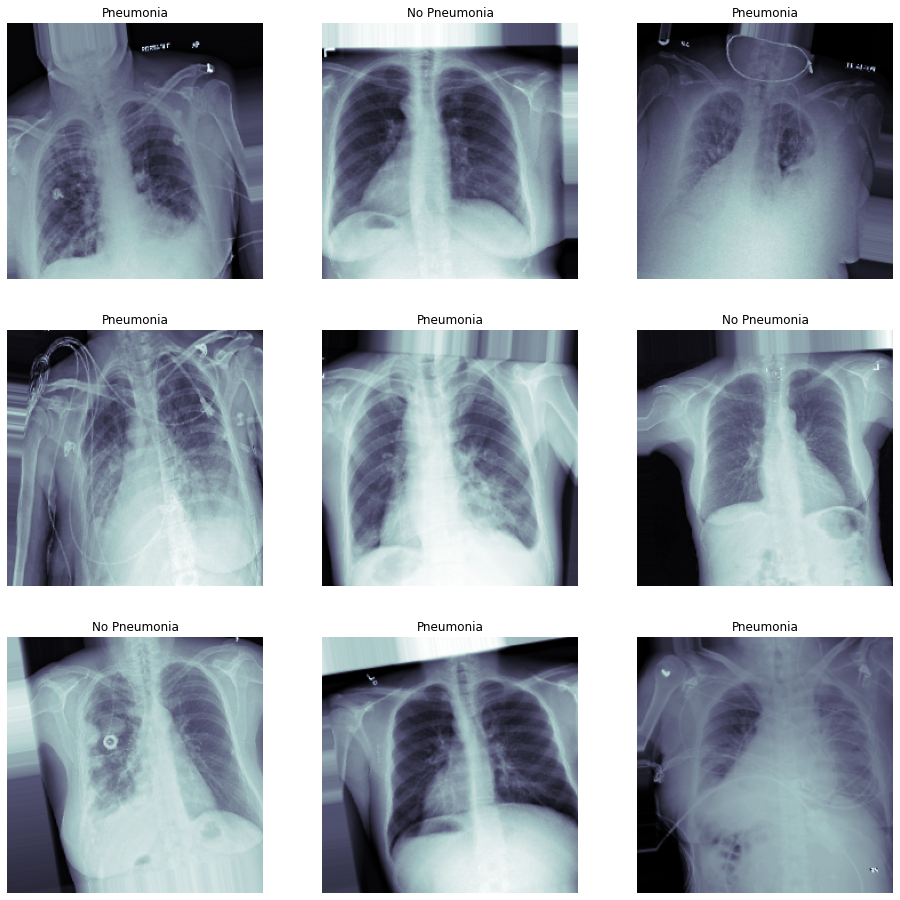

In [24]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [11]:
# def load_pretrained_model(vargs):
    

    
    # Todo
    
    # return vgg_model

model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 10s 0us/step


In [12]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

In [13]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [43]:
# Keeping all trined weight in the network
for layer in vgg_model.layers[0:18]:
    layer.trainable = False

In [44]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True


In [45]:
# def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo

## FIRST EXPERIMENT
# In the first few experiments we will freeze all layers in the original trained VGG16 network and add a convolutional layer.
# Adding extra convolution layer with a pooling layer
my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Conv2D(512,(7,7), padding='same'))
my_model.add(MaxPooling2D(pool_size=(7,7)))
my_model.add(Flatten())
my_model.add(Dense(1, activation='sigmoid'))
    
# Learning metrics
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
    
    # return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [46]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

weight_path="{}_my_model.best.hdf5".format('#1_experiment')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [47]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [48]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
229/229 [==============================] - 60s 261ms/step - loss: 0.6986 - binary_accuracy: 0.6092 - val_loss: 0.9079 - val_binary_accuracy: 0.6667

Epoch 00001: val_loss improved from inf to 0.90794, saving model to #1_experiment_my_model.best.hdf5
Epoch 2/30
229/229 [==============================] - 59s 260ms/step - loss: 0.6309 - binary_accuracy: 0.6581 - val_loss: 1.0620 - val_binary_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.90794
Epoch 3/30
229/229 [==============================] - 60s 262ms/step - loss: 0.6103 - binary_accuracy: 0.6747 - val_loss: 0.9152 - val_binary_accuracy: 0.6667

Epoch 00003: val_loss did not improve from 0.90794
Epoch 4/30
229/229 [==============================] - 59s 259ms/step - loss: 0.5945 - binary_accuracy: 0.6917 - val_loss: 0.8826 - val_binary_accuracy: 0.6667

Epoch 00004: val_loss improved from 0.90794 to 0.88263, saving model to #1_experiment_my_model.best.hdf5
Epoch 5/30
229/229 [==============================] 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [49]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

6/6 [==============================] - 0s 34ms/step


In [11]:
# Import packages

from sklearn.preprocessing import binarize

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

In [12]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y, p_y):
    
# Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
def calc_f1(prec,recall):
# Todo
    return 2*(prec*recall)/(prec+recall)

# Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    # return 

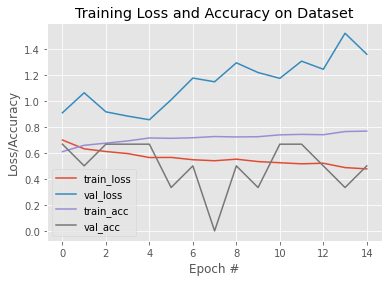

In [52]:
## plot figures

# Todo

plot_history(history)

In [ ]:
# Training set showed gradual improvement in accuracy and loss function, but validation set showed worsening performance. 

In [54]:
## SECOND EXPERIMENT

my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Conv2D(512,(7,7), padding='same'))
my_model.add(MaxPooling2D(pool_size=(7,7)))
my_model.add(Flatten())


# Adding 2 extra Dense layers
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(1, activation='sigmoid'))

    
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [55]:
# Model checkpoints

weight_path="{}_my_model.best.hdf5".format('#2_experiment')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [57]:
# Compile and train model
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
229/229 [==============================] - 59s 259ms/step - loss: 0.6533 - binary_accuracy: 0.6314 - val_loss: 0.8594 - val_binary_accuracy: 0.3333

Epoch 00001: val_loss improved from inf to 0.85943, saving model to #2_experiment_my_model.best.hdf5
Epoch 2/30
229/229 [==============================] - 59s 257ms/step - loss: 0.6269 - binary_accuracy: 0.6485 - val_loss: 0.9178 - val_binary_accuracy: 0.3333

Epoch 00002: val_loss did not improve from 0.85943
Epoch 3/30
229/229 [==============================] - 59s 259ms/step - loss: 0.6019 - binary_accuracy: 0.6703 - val_loss: 0.8662 - val_binary_accuracy: 0.6667

Epoch 00003: val_loss did not improve from 0.85943
Epoch 4/30
229/229 [==============================] - 60s 260ms/step - loss: 0.5898 - binary_accuracy: 0.6825 - val_loss: 1.1768 - val_binary_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.85943
Epoch 5/30
229/229 [==============================] - 59s 259ms/step - loss: 0.5932 - binary_accuracy: 0.6

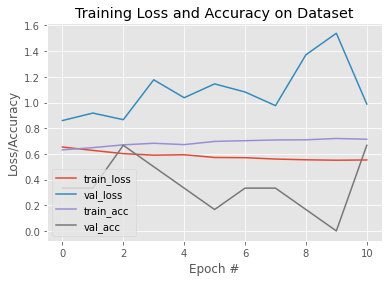

In [58]:
# Plot performance
plot_history(history)

In [ ]:
# Similar pattern is noted in #2 experiment to #1 experiment

In [59]:
# THIRD EXPERIMENT

# changing batch size

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 6
                                         )

val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )
val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                      directory=None, 
                                      x_col = 'path',
                                      y_col = 'pneumonia_class',
                                      class_mode = 'binary',
                                      target_size = (224,224), 
                                      batch_size = 4)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [60]:
# Fine-tuning the model


# Adding drop-out layers
my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Conv2D(512,(7,7), padding='same'))
my_model.add(MaxPooling2D(pool_size=(7,7)))
my_model.add(Flatten())

my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(256,activation='relu'))
my_model.add(Dense(1, activation='sigmoid'))
    
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [61]:
# Model checkpoints

weight_path="{}_my_model.best.hdf5".format('#3_experiment')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [62]:
# Compile and train model

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
382/382 [==============================] - 63s 166ms/step - loss: 0.7417 - binary_accuracy: 0.5201 - val_loss: 0.6774 - val_binary_accuracy: 0.6667

Epoch 00001: val_loss improved from inf to 0.67740, saving model to #3_experiment_my_model.best.hdf5
Epoch 2/30
382/382 [==============================] - 63s 164ms/step - loss: 0.7181 - binary_accuracy: 0.5476 - val_loss: 0.6492 - val_binary_accuracy: 0.8333

Epoch 00002: val_loss improved from 0.67740 to 0.64922, saving model to #3_experiment_my_model.best.hdf5
Epoch 3/30
382/382 [==============================] - 62s 163ms/step - loss: 0.6973 - binary_accuracy: 0.5725 - val_loss: 0.6760 - val_binary_accuracy: 0.6667

Epoch 00003: val_loss did not improve from 0.64922
Epoch 4/30
382/382 [==============================] - 63s 164ms/step - loss: 0.6745 - binary_accuracy: 0.5974 - val_loss: 0.6925 - val_binary_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.64922
Epoch 5/30
382/382 [==============================] 

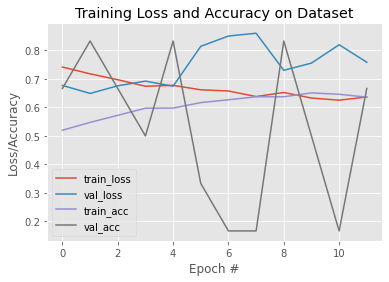

In [63]:
# Plot performance
plot_history(history)

In [ ]:
# This is a failed experiment, so further optimisation is required. 

In [64]:
# FOURTH EXPERIMENT

# Fine-tuning the model



# Adding batch normalisation layers

my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Conv2D(512,(7,7), padding='same'))
my_model.add(MaxPooling2D(pool_size=(7,7)))
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(1, activation='sigmoid'))
    
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [65]:
# Model checkpoints

weight_path="{}_my_model.best.hdf5".format('#4_experiment')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [66]:
# Compile and train model

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
382/382 [==============================] - 63s 165ms/step - loss: 1.0381 - binary_accuracy: 0.5074 - val_loss: 0.5962 - val_binary_accuracy: 0.8333

Epoch 00001: val_loss improved from inf to 0.59624, saving model to #4_experiment_my_model.best.hdf5
Epoch 2/30
382/382 [==============================] - 63s 165ms/step - loss: 0.9890 - binary_accuracy: 0.5162 - val_loss: 0.5839 - val_binary_accuracy: 0.8333

Epoch 00002: val_loss improved from 0.59624 to 0.58394, saving model to #4_experiment_my_model.best.hdf5
Epoch 3/30
382/382 [==============================] - 64s 167ms/step - loss: 0.9665 - binary_accuracy: 0.5070 - val_loss: 0.6073 - val_binary_accuracy: 0.8333

Epoch 00003: val_loss did not improve from 0.58394
Epoch 4/30
382/382 [==============================] - 63s 164ms/step - loss: 0.9075 - binary_accuracy: 0.5397 - val_loss: 0.6106 - val_binary_accuracy: 0.8333

Epoch 00004: val_loss did not improve from 0.58394
Epoch 5/30
382/382 [==============================] 

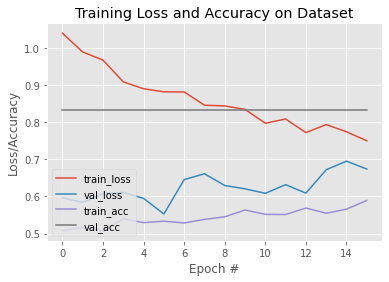

In [67]:
# Plot performance
plot_history(history)

In [ ]:
# There is definit improvement after using batch normalization and we have a reasonable model performing a classification of pneumonia with 83% accuracy, however, the validation loss has been increasing.
# The training set showed much slower improvement in accuracy and loss, but in the right direction.

In [75]:
# FIFTH EXPERIMENT
# As batch normalization and drop out improved the model, we can try to improve further by changing the learning rate with learning rate scheduler
# Fine-tuning the model



# Adding batch normalization layers and change activation to 'softmax'

my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Conv2D(512,(7,7), padding='same'))
my_model.add(MaxPooling2D(pool_size=(7,7)))
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(1, activation='sigmoid'))


optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [76]:
# Model checkpoints

weight_path="{}_my_model.best.hdf5".format('#5_experiment')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [77]:
# Using learning rate scheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [78]:
# Compile and train model

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
callback = LearningRateScheduler(scheduler)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
382/382 [==============================] - 63s 164ms/step - loss: 1.0329 - binary_accuracy: 0.5114 - val_loss: 0.9688 - val_binary_accuracy: 0.1667

Epoch 00001: val_loss improved from inf to 0.96881, saving model to #5_experiment_my_model.best.hdf5
Epoch 2/30
382/382 [==============================] - 62s 164ms/step - loss: 0.9876 - binary_accuracy: 0.5105 - val_loss: 0.9795 - val_binary_accuracy: 0.1667

Epoch 00002: val_loss did not improve from 0.96881
Epoch 3/30
382/382 [==============================] - 62s 162ms/step - loss: 0.9526 - binary_accuracy: 0.5223 - val_loss: 0.8986 - val_binary_accuracy: 0.3333

Epoch 00003: val_loss improved from 0.96881 to 0.89855, saving model to #5_experiment_my_model.best.hdf5
Epoch 4/30
382/382 [==============================] - 63s 164ms/step - loss: 0.9198 - binary_accuracy: 0.5210 - val_loss: 0.8443 - val_binary_accuracy: 0.3333

Epoch 00004: val_loss improved from 0.89855 to 0.84433, saving model to #5_experiment_my_model.best.hdf

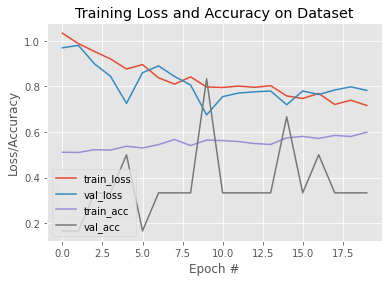

In [79]:
# Plot performance
plot_history(history)

In [ ]:
# The learning rate scheduler had no beneficial effect on the training performance.

In [37]:
# SIXTH EXPERIMENT
# From the 5 previous experiments, #4 had the best performance, so we can repeat the same experiment but this time by using the 
# final layer of the VGG16 as a trained layer

model = VGG16(include_top=True, weights='imagenet')

transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

for layer in vgg_model.layers[0:17]:
    layer.trainable = False
    
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

553467904/553467096 [==============================] - 15s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [17]:
# Fine-tuning the model

my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(1, activation='sigmoid'))
    
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [24]:
# Model checkpoints

weight_path="{}_my_model.best.hdf5".format('#6_experiment')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=30)

callbacks_list = [checkpoint, early]

In [25]:
# Compile and train model

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 50, 
                          callbacks = callbacks_list)

Epoch 1/50
229/229 [==============================] - 57s 251ms/step - loss: 0.9946 - binary_accuracy: 0.5384 - val_loss: 1.4293 - val_binary_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.42926, saving model to #6_experiment_my_model.best.hdf5
Epoch 2/50
229/229 [==============================] - 58s 252ms/step - loss: 0.9486 - binary_accuracy: 0.5507 - val_loss: 0.3452 - val_binary_accuracy: 1.0000

Epoch 00002: val_loss improved from 1.42926 to 0.34518, saving model to #6_experiment_my_model.best.hdf5
Epoch 3/50
229/229 [==============================] - 58s 255ms/step - loss: 0.9152 - binary_accuracy: 0.5611 - val_loss: 0.2925 - val_binary_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.34518 to 0.29245, saving model to #6_experiment_my_model.best.hdf5
Epoch 4/50
229/229 [==============================] - 57s 247ms/step - loss: 0.8956 - binary_accuracy: 0.5454 - val_loss: 0.4858 - val_binary_accuracy: 0.8333

Epoch 00004: val_loss did not improve from 0.

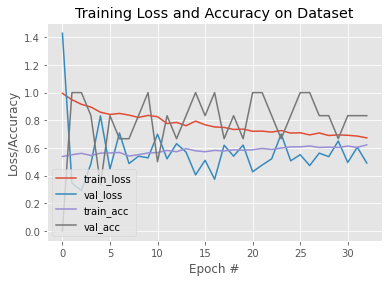

In [26]:
# Plot performance
plot_history(history)

In [ ]:
# This seems a reasonable performance on the validation set, so we can assess the model further.

In [41]:
from keras.models import load_model
my_model = load_model('/home/workspace/#6_experiment_my_model.best.hdf5')

In [42]:
my_model.load_weights('/home/workspace/#6_experiment_my_model.best.hdf5')
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

6/6 [==============================] - 4s 632ms/step


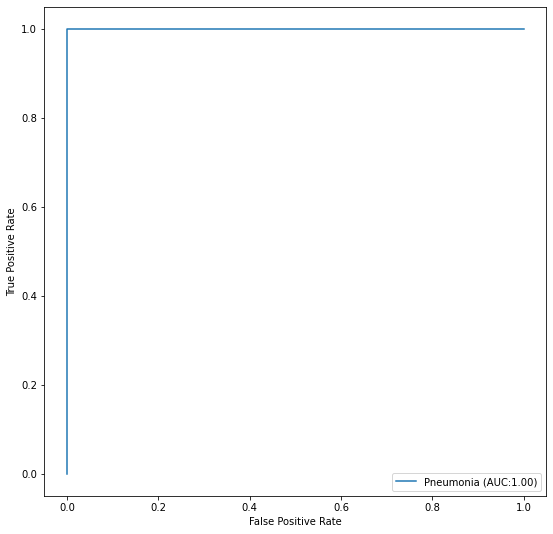

In [43]:
plot_auc(valY, pred_Y)

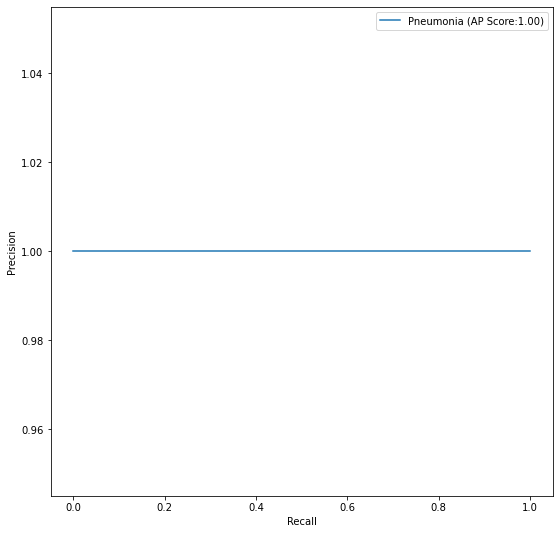

In [30]:
plot_precision_recall_curve(valY,pred_Y)

In [80]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 1.0
Threshold is: 0.32190272
F1 Score is: 1.0


In [81]:
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 1.0
Threshold is: 0.32190272
F1 Score is: 1.0


In [ ]:
# This model's performance is very good. 

In [12]:
# SEVENTH EXPERIMENT
# Similar to #4 experiment, but will let the network train for more epochs

model = VGG16(include_top=True, weights='imagenet')


553467904/553467096 [==============================] - 6s 0us/step


In [13]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

In [14]:
for layer in vgg_model.layers[0:18]:
    layer.trainable = False
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True


In [15]:
# Fine tuning model

my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Conv2D(512,(7,7), padding='same'))
my_model.add(MaxPooling2D(pool_size=(7,7)))
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(1, activation='sigmoid'))
    
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [16]:
weight_path="{}_my_model.best.hdf5".format('#7_experiment')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=30)

callbacks_list = [checkpoint, early]

In [17]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 50, 
                          callbacks = callbacks_list)

Epoch 1/50
229/229 [==============================] - 66s 290ms/step - loss: 1.0404 - binary_accuracy: 0.5009 - val_loss: 0.8184 - val_binary_accuracy: 0.1667

Epoch 00001: val_loss improved from inf to 0.81836, saving model to #7_experiment_my_model.best.hdf5
Epoch 2/50
229/229 [==============================] - 57s 250ms/step - loss: 0.9769 - binary_accuracy: 0.5148 - val_loss: 0.5074 - val_binary_accuracy: 0.8333

Epoch 00002: val_loss improved from 0.81836 to 0.50744, saving model to #7_experiment_my_model.best.hdf5
Epoch 3/50
229/229 [==============================] - 59s 259ms/step - loss: 0.9952 - binary_accuracy: 0.5131 - val_loss: 0.5143 - val_binary_accuracy: 0.8333

Epoch 00003: val_loss did not improve from 0.50744
Epoch 4/50
229/229 [==============================] - 60s 262ms/step - loss: 0.9414 - binary_accuracy: 0.5271 - val_loss: 0.5748 - val_binary_accuracy: 0.8333

Epoch 00004: val_loss did not improve from 0.50744
Epoch 5/50
229/229 [==============================] 

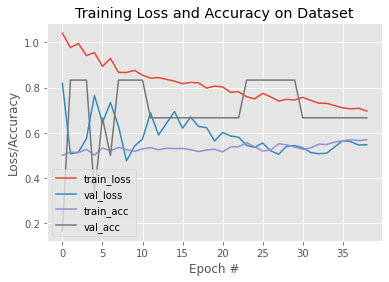

In [20]:
# Plot performance
plot_history(history)

In [31]:
my_model = load_model('/home/workspace/#7_experiment_my_model.best.hdf5')
my_model.load_weights('/home/workspace/#7_experiment_my_model.best.hdf5')
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

6/6 [==============================] - 4s 617ms/step


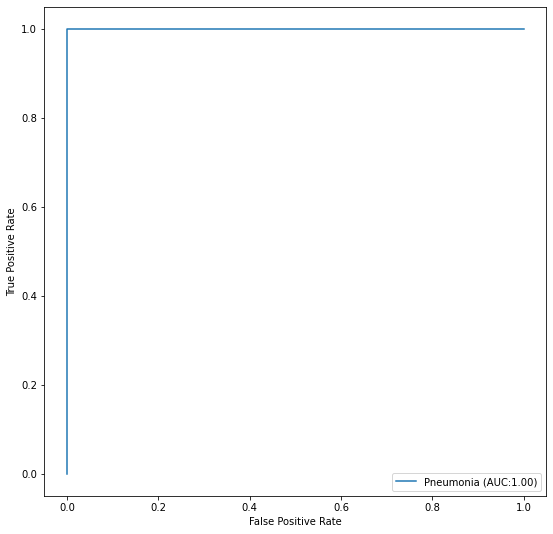

In [32]:
plot_auc(valY, pred_Y)

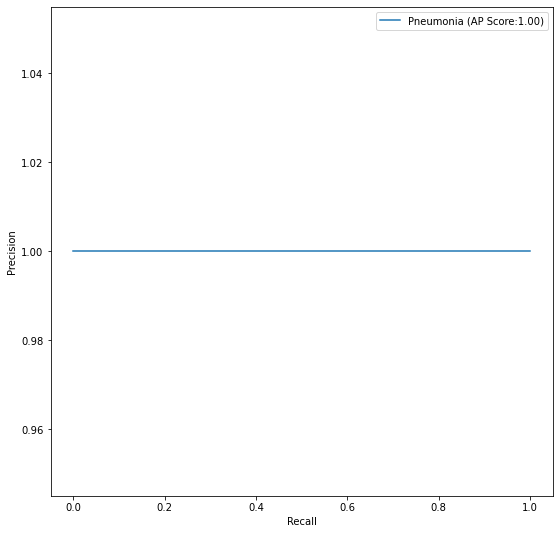

In [33]:
plot_precision_recall_curve(valY, pred_Y)

In [73]:
precision, recall, thresholds = precision_recall_curve(valY,pred_Y)
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 1.0
Threshold is: 0.32190272
F1 Score is: 1.0


In [74]:
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 1.0
Threshold is: 0.32190272
F1 Score is: 1.0


In [ ]:
# This model has a very good performance.

In [18]:
# EIGHTH EXPERIMENT
# Will repeat third experiment by using top convolutional layer in VGG16 to train

# Fine-tuning the model

my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(1, activation='sigmoid'))
    
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [19]:
weight_path="{}_my_model.best.hdf5".format('#8_experiment')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=20)

callbacks_list = [checkpoint, early]

In [20]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 50, 
                          callbacks = callbacks_list)

Epoch 1/50
229/229 [==============================] - 69s 301ms/step - loss: 0.8287 - binary_accuracy: 0.5240 - val_loss: 0.7131 - val_binary_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.71305, saving model to #8_experiment_my_model.best.hdf5
Epoch 2/50
229/229 [==============================] - 60s 260ms/step - loss: 0.6977 - binary_accuracy: 0.5533 - val_loss: 0.6702 - val_binary_accuracy: 0.5000

Epoch 00002: val_loss improved from 0.71305 to 0.67022, saving model to #8_experiment_my_model.best.hdf5
Epoch 3/50
229/229 [==============================] - 60s 261ms/step - loss: 0.6789 - binary_accuracy: 0.5812 - val_loss: 0.5755 - val_binary_accuracy: 0.6667

Epoch 00003: val_loss improved from 0.67022 to 0.57550, saving model to #8_experiment_my_model.best.hdf5
Epoch 4/50
229/229 [==============================] - 60s 262ms/step - loss: 0.6768 - binary_accuracy: 0.5895 - val_loss: 0.6296 - val_binary_accuracy: 0.6667

Epoch 00004: val_loss did not improve from 0.5755

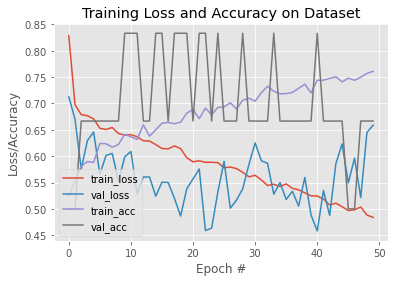

In [24]:
# Plot performance
plot_history(history)

In [ ]:
#  This is a good experiment showing conversion in both training and validation sets up to epoch 45, best model was achieved at epoch 41 with accuracy of 83%, then the network stopped learning on the validation set.


In [34]:
from keras.models import load_model
my_model = load_model('/home/workspace/#8_experiment_my_model.best.hdf5')
my_model.load_weights('/home/workspace/#8_experiment_my_model.best.hdf5')
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

6/6 [==============================] - 3s 581ms/step


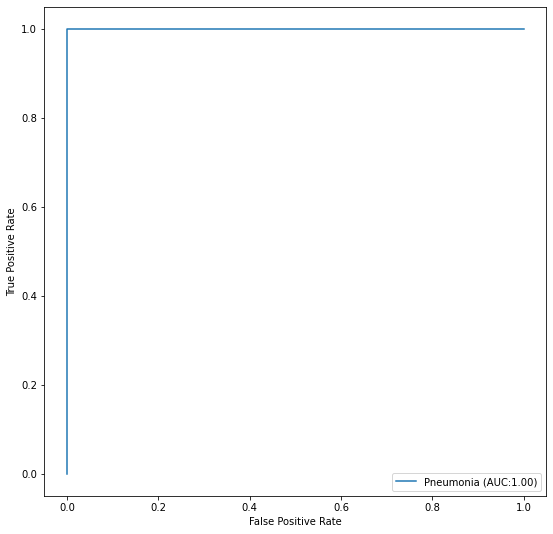

In [35]:
plot_auc(valY, pred_Y)

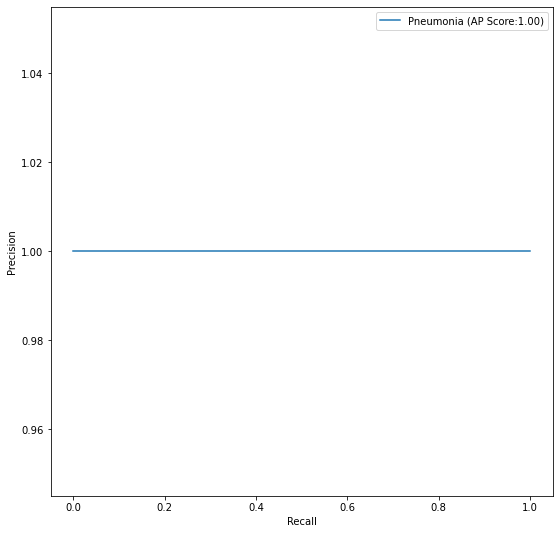

In [36]:
plot_precision_recall_curve(valY, pred_Y)

In [86]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.16666666666666666
Recall is: 1.0
Threshold is: 0.089872755
F1 Score is: 0.2857142857142857


In [ ]:
# This model's performance is prohibitively low

In [38]:
# NINTH EXPERIMENT
# Will repeat experiment #6 by using zero mean and standard deviation normalization in the data augmentation rather than rescaling. 

# Fine-tuning the model

my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))
my_model.add(Dense(1, activation='sigmoid'))
    
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [14]:

    
train_idg = ImageDataGenerator(samplewise_center=True,
                               samplewise_std_normalization=True,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=10, 
                              shear_range = 0.1,
                              zoom_range=0.1)



train_gen = train_idg.flow_from_dataframe(dataframe=train_df, directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 10
                                         )

    
val_idg = ImageDataGenerator(samplewise_center=True,
                               samplewise_std_normalization=True,
                                 )


val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                      directory=None, 
                                      x_col = 'path',
                                      y_col = 'pneumonia_class',
                                      class_mode = 'binary',
                                      target_size = (224,224), 
                                      batch_size = 6)
 

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [15]:
valX, valY = val_gen.next()

In [41]:
weight_path="{}_my_model.best.hdf5".format('#9_experiment')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=20)

callbacks_list = [checkpoint, early]

In [19]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 50, 
                          callbacks = callbacks_list)

Epoch 1/50
229/229 [==============================] - 70s 305ms/step - loss: 1.0200 - binary_accuracy: 0.5275 - val_loss: 1.1021 - val_binary_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.10207, saving model to #9_experiment_my_model.best.hdf5
Epoch 2/50
229/229 [==============================] - 60s 261ms/step - loss: 0.9551 - binary_accuracy: 0.5493 - val_loss: 1.1914 - val_binary_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 1.10207
Epoch 3/50
229/229 [==============================] - 63s 273ms/step - loss: 0.9031 - binary_accuracy: 0.5576 - val_loss: 0.6744 - val_binary_accuracy: 0.6667

Epoch 00003: val_loss improved from 1.10207 to 0.67441, saving model to #9_experiment_my_model.best.hdf5
Epoch 4/50
229/229 [==============================] - 62s 269ms/step - loss: 0.9105 - binary_accuracy: 0.5537 - val_loss: 0.8945 - val_binary_accuracy: 0.3333

Epoch 00004: val_loss did not improve from 0.67441
Epoch 5/50
229/229 [==============================] 

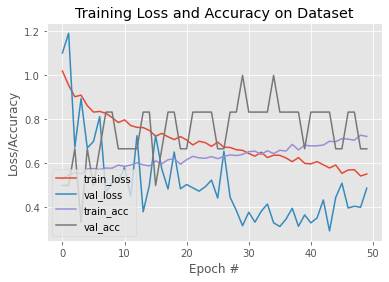

In [20]:
# Plot performance
plot_history(history)

In [37]:
from keras.models import load_model
my_model = load_model('/home/workspace/#9_experiment_my_model.best.hdf5')
my_model.load_weights('/home/workspace/#9_experiment_my_model.best.hdf5')
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

6/6 [==============================] - 4s 603ms/step


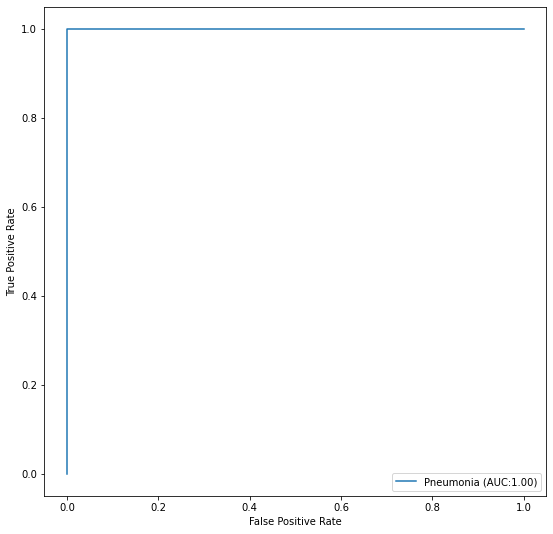

In [38]:
plot_auc(valY, pred_Y)

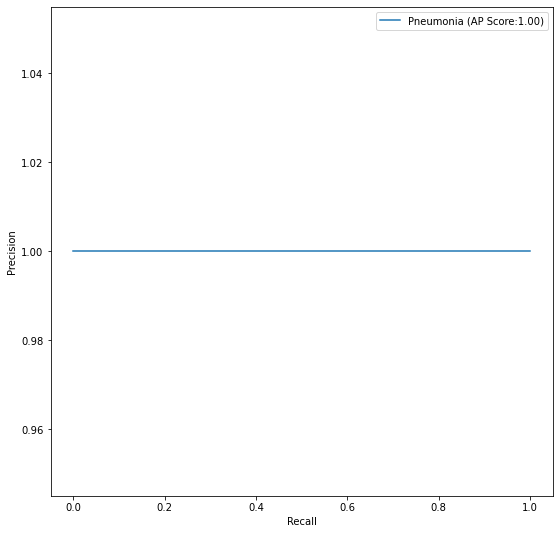

In [39]:
plot_precision_recall_curve(valY, pred_Y)

In [19]:
precision, recall, thresholds = precision_recall_curve(valY,pred_Y)
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 1.0
Threshold is: 0.90239173
F1 Score is: 1.0


In [20]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 1.0
Threshold is: 0.90239173
F1 Score is: 1.0


In [ ]:
# This model by far has the best performance with high AUC, F1 score, precision and recall. 

No handles with labels found to put in legend.


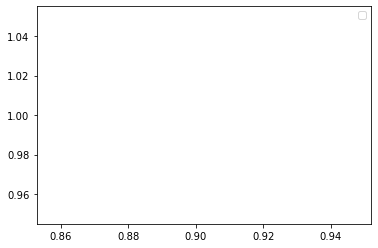

In [24]:
plt.plot(thresholds[idx], calc_f1(precision[idx],recall[idx]))
plt.legend()
#plt.set_xlabel('Threshold')
#plt.set_ylabel('F1 Score')

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

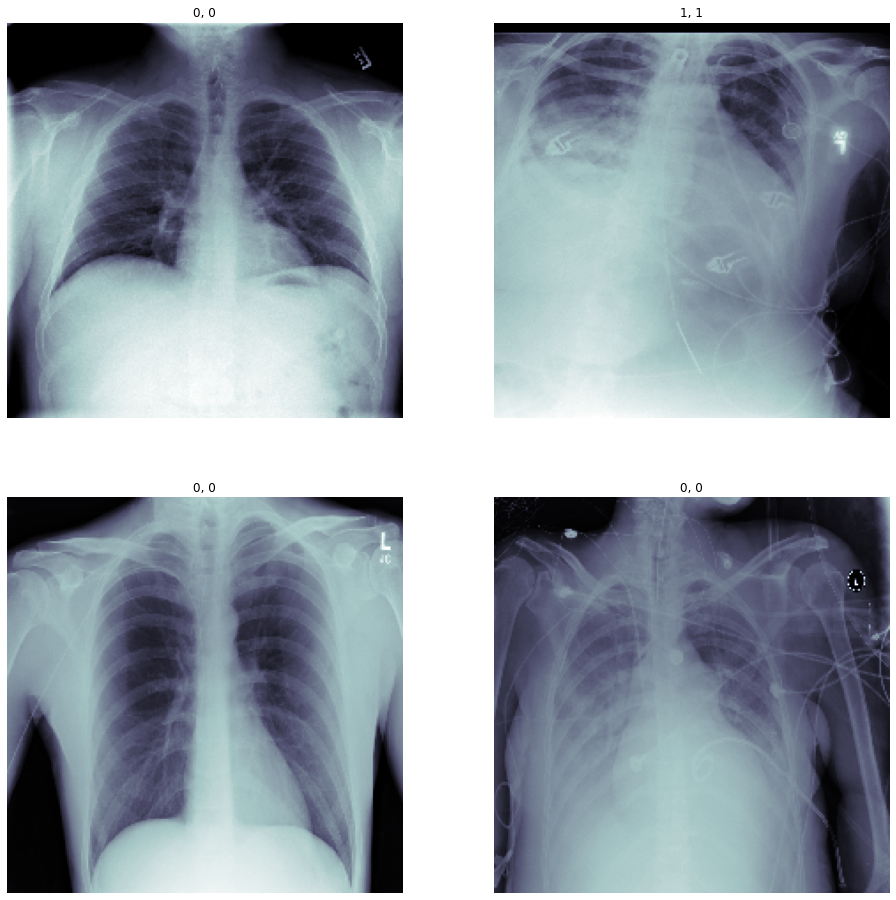

In [58]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1


fig, m_axs = plt.subplots(2, 2, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.47:  # Lowering threshold showed better precision and more correct prediction
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.47: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [59]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)